# HOMEWORK 5

In this homework you are going to implement the **Floyd-Steinberg dithering** algorithm. Dithering, in general, means that we are adding noise to the signal (in our case digital image) in order to perceive it better. In other words, by adding the noise the objective quality will be worse but the subjective quality will be better (i.e. the image will "look" better).

The details of FS dithering can be found in this [wiki](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering) page. In order to implement the dithering, we will implement the following steps:
* Define colour pallette
* Quantize the image to obtain the baseline and compute the average quantization error
* Implement FS dithering and compute the average quantization error

You will also have to answer the question at the end of this notebook.

Note: In this homework, you will have the chance to earn some extra points. See the "Bonus" section at the end of the notebook. Good luck!

As always, you are encouraged to use your own images :-)

In [15]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [15, 10]

Let's load the image.

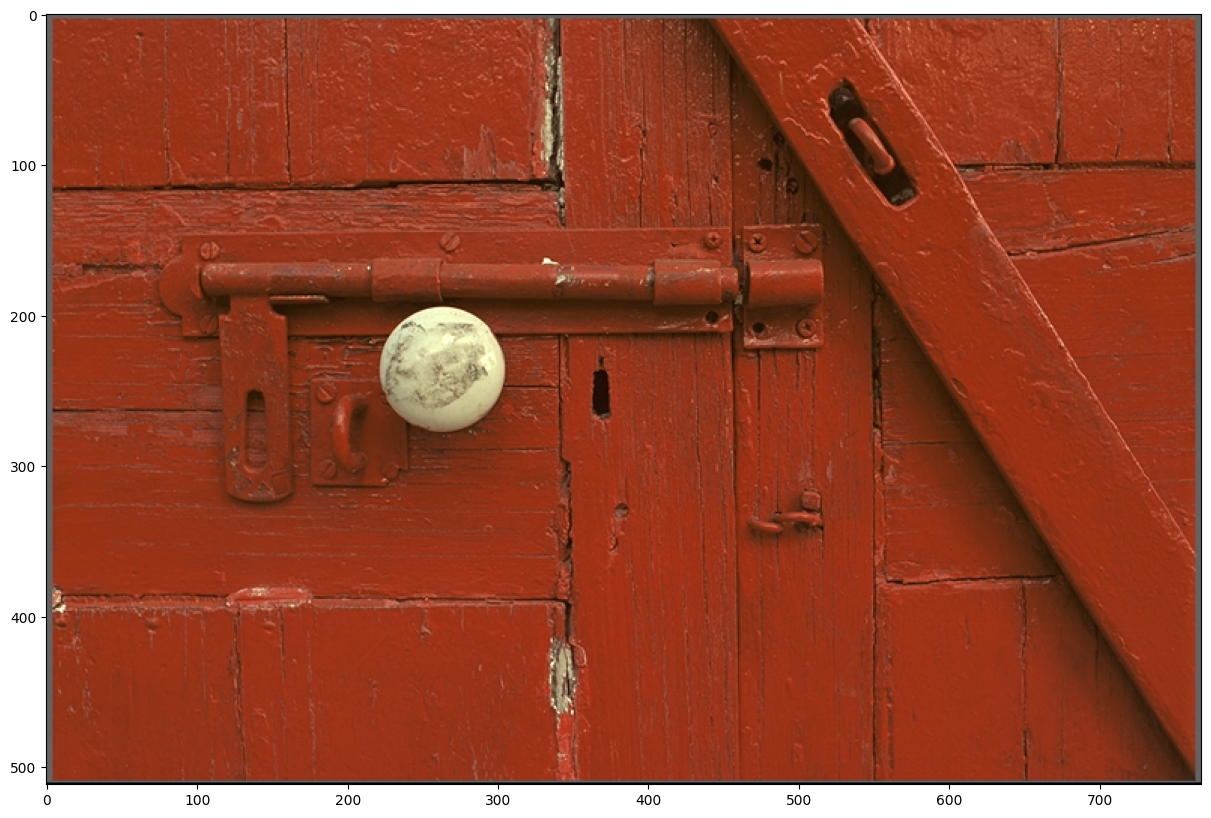

In [16]:
# Load image
img = cv2.imread("kodim02.png")
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Plot it
plt.imshow(img)

Let's start with gray tones first.

In [17]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0], [64, 64, 64], [192, 192, 192], [255, 255, 255]])

Using the colour pallette, let's quantize the original image.

In [18]:
# Cast the image to float
img = img.astype(float)

# Prepare for quantization
rows, cols, channels = img.shape
quantized = np.zeros_like(img)

# Apply quantization
for r in range(rows):
    for c in range(cols):
        # Extract the original pixel value
        pixel = img[r, c, :]

        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        distances = np.linalg.norm(colors - pixel, axis=1)
        closest_idx = np.argmin(distances)
        new_pixel = colors[closest_idx]

        # Apply quantization
        quantized[r, c, :] = new_pixel

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


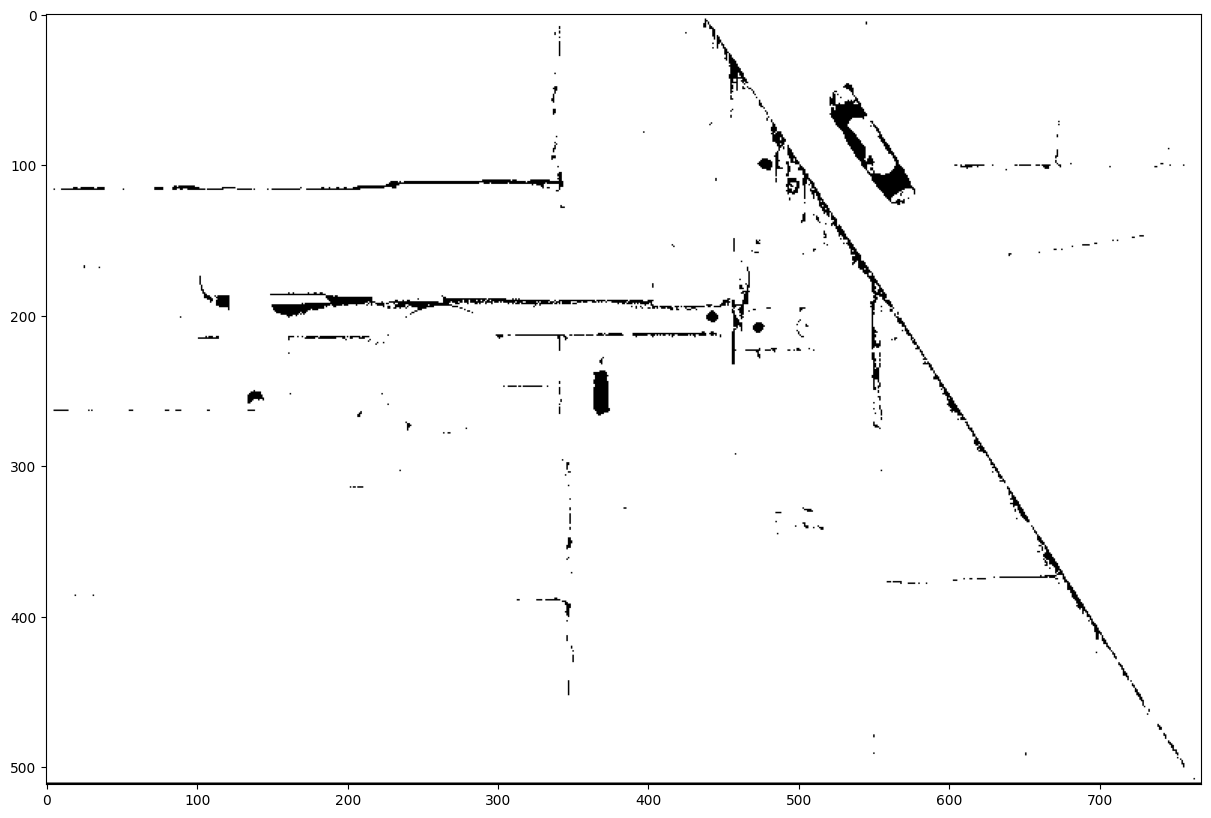

In [19]:
# Show quantized image (don't forget to cast back to uint8)
plt.imshow(quantized)

In [20]:
# Compute average quantization error
avg_quant_error = np.mean(np.abs(img - quantized))
avg_quant_error

np.float64(42.38778093126085)

#### Floyd-Steinberg Dithering
We are now going to implement the FS dithering and compare it to the optimally quantized image we have calculated above.

In [21]:
# Make a temporal copy of the original image, we will need it for error diffusion
img_tmp = np.copy(img)
dithering = np.zeros_like(img)

for r in range(1, rows - 1):
    for c in range(1, cols - 1):
        # Extract the original pixel value
        pixel = img_tmp[r, c, :]
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        distances = np.linalg.norm(colors - pixel, axis=1)
        closest_idx = np.argmin(distances)
        new_pixel = colors[closest_idx]

        # Compute quantization error
        quant_error = pixel - new_pixel

        # Diffuse the quantization error accroding to the FS diffusion matrix
        # Note: You may need more than one line of code here
        img_tmp[r, c + 1, :] += quant_error * 7 / 16
        img_tmp[r + 1, c - 1, :] += quant_error * 3 / 16
        img_tmp[r + 1, c, :] += quant_error * 5 / 16
        img_tmp[r + 1, c + 1, :] += quant_error * 1 / 16

        # Apply dithering
        dithering[r, c, :] = new_pixel

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


(<Axes: >, <matplotlib.image.AxesImage at 0x11f780f50>)

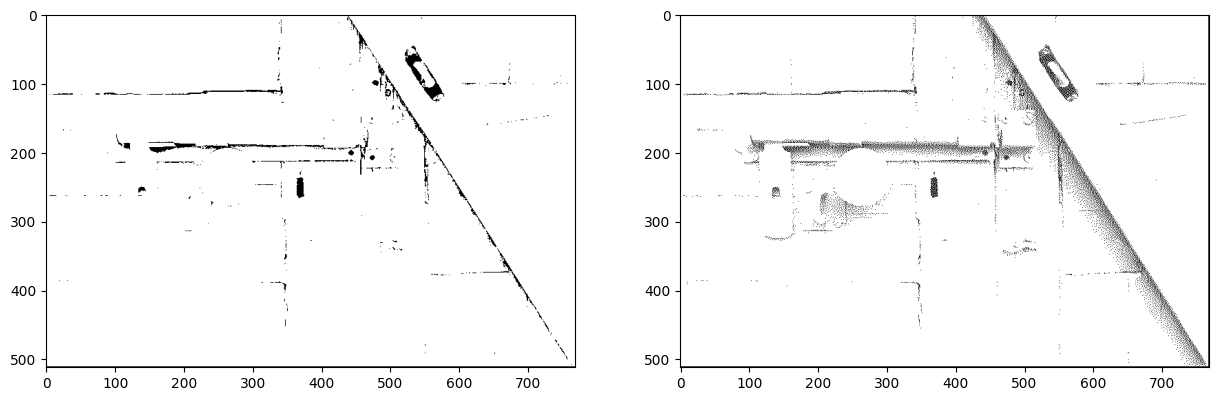

In [22]:
# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(quantized)  # optimally quantized
plt.subplot(122), plt.imshow(dithering)  # dithering

In [23]:
# Compute average quantization error for dithered image
avg_dith_error = np.mean(np.abs(img - dithering))
avg_dith_error

np.float64(49.06040700276693)

### Questions
* Which image has higher quantization error? Optimally quantized or dithered?
* Which image looks better to you?
* Can you repeat the same process using only two colours: black and white? Show me :-)

### Answers

1. **Which image has higher quantization error?**  
   The **dithered** image has a higher average quantization error. This is by design — Floyd-Steinberg dithering deliberately *diffuses* the quantization error from each pixel to its neighbours. As a result, individual pixel values deviate further from the original than in optimal (nearest-colour) quantization. Optimal quantization minimises per-pixel error independently, so its average absolute error is always ≤ that of dithering.

2. **Which image looks better?**  
   The **dithered** image looks significantly better to the human eye despite its higher numerical error. Our visual system is much more sensitive to *spatial patterns* (banding, contouring) than to uncorrelated noise. Dithering trades precise per-pixel accuracy for perceptually smoother gradients, effectively exploiting the eye's spatial low-pass filtering.

### Black & White (2 colours)

In [24]:
# Two-colour palette: pure black and pure white
bw_colors = np.array([[0, 0, 0], [255, 255, 255]])

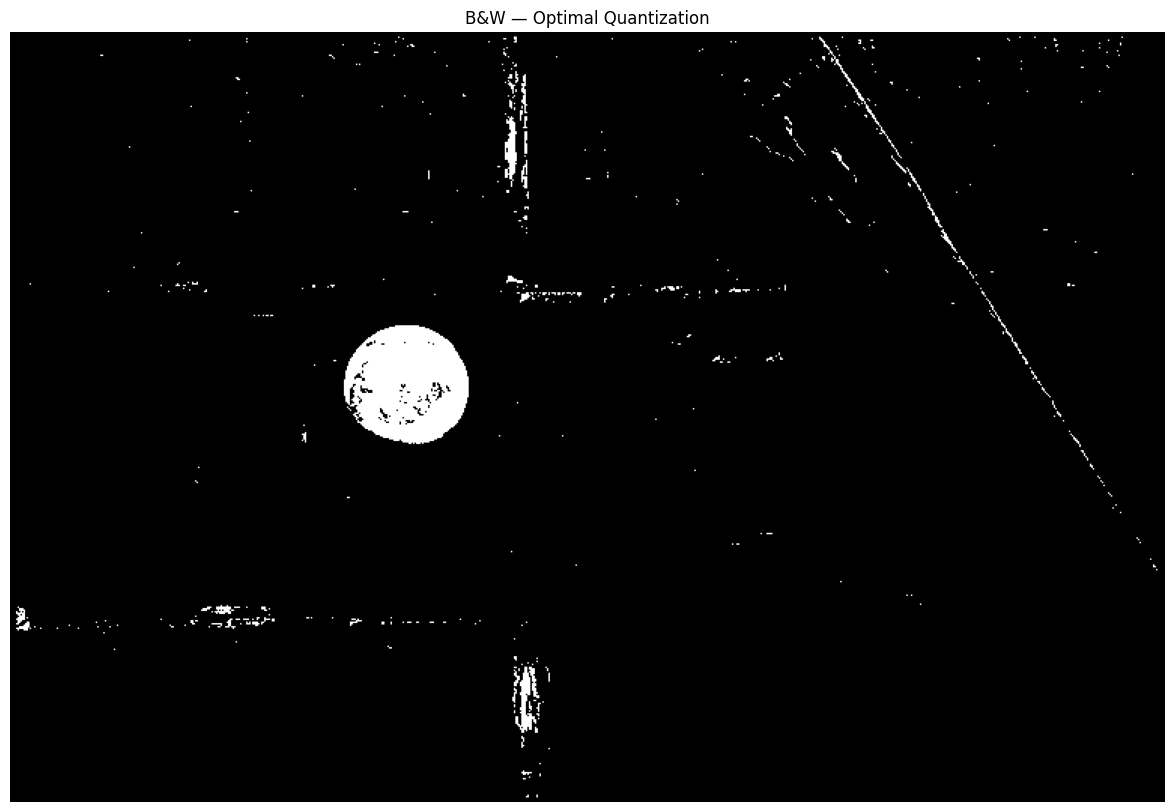

Avg quantization error (B&W optimal): 75.12


In [25]:
# --- Optimal quantization (B&W) ---
bw_quantized = np.zeros_like(img)
for r in range(rows):
    for c in range(cols):
        pixel = img[r, c, :]
        distances = np.linalg.norm(bw_colors - pixel, axis=1)
        bw_quantized[r, c, :] = bw_colors[np.argmin(distances)]

plt.imshow(bw_quantized.astype(np.uint8))
plt.title("B&W — Optimal Quantization")
plt.axis("off")
plt.show()

print(
    f"Avg quantization error (B&W optimal): {np.mean(np.abs(img - bw_quantized)):.2f}"
)

In [26]:
# --- Floyd-Steinberg dithering (B&W) ---
img_tmp_bw = np.copy(img)
bw_dithering = np.zeros_like(img)

for r in range(1, rows - 1):
    for c in range(1, cols - 1):
        pixel = img_tmp_bw[r, c, :]
        distances = np.linalg.norm(bw_colors - pixel, axis=1)
        new_pixel = bw_colors[np.argmin(distances)]

        quant_error = pixel - new_pixel

        # Floyd-Steinberg error diffusion
        img_tmp_bw[r, c + 1, :] += quant_error * 7 / 16
        img_tmp_bw[r + 1, c - 1, :] += quant_error * 3 / 16
        img_tmp_bw[r + 1, c, :] += quant_error * 5 / 16
        img_tmp_bw[r + 1, c + 1, :] += quant_error * 1 / 16

        bw_dithering[r, c, :] = new_pixel

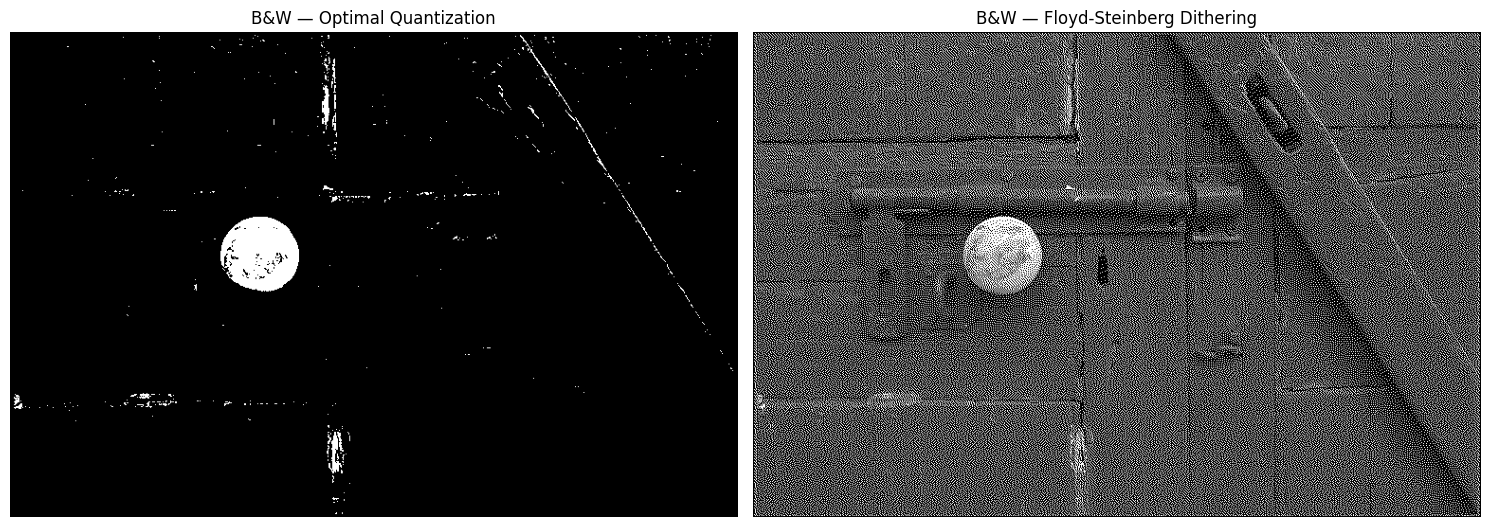

Avg quantization error  (B&W optimal):   75.12
Avg quantization error  (B&W dithered):  103.75


In [27]:
# --- Compare B&W results ---
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(bw_quantized.astype(np.uint8))
axes[0].set_title("B&W — Optimal Quantization")
axes[0].axis("off")

axes[1].imshow(bw_dithering.astype(np.uint8))
axes[1].set_title("B&W — Floyd-Steinberg Dithering")
axes[1].axis("off")

plt.tight_layout()
plt.show()

bw_quant_err = np.mean(np.abs(img - bw_quantized))
bw_dith_err = np.mean(np.abs(img - bw_dithering))
print(f"Avg quantization error  (B&W optimal):   {bw_quant_err:.2f}")
print(f"Avg quantization error  (B&W dithered):  {bw_dith_err:.2f}")

### Bonus Points

Repeat the homework using a diffrerent image pallette. For instance, you can use an optimal colour
pallette that we can calculate via k-means algorithm. The following snippet of code will give you the 16
optimal colours for your original image.

In [28]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=16).fit(np.reshape(img, (-1, 3)))
colors = kmeans.cluster_centers_

Apply FS dithering the same way you did before.
* How does the result look like to you?
* What happens if we use 32 colours?
* And what happens if we use 256 colours?

In [29]:
def quantize_and_dither(
    image: np.ndarray, palette: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """Apply optimal quantization and Floyd-Steinberg dithering.

    Parameters
    ----------
    image : np.ndarray
        Float64 source image of shape (H, W, 3).
    palette : np.ndarray
        Colour palette of shape (K, 3).

    Returns
    -------
    quantized : np.ndarray
        Optimally quantized image (float64).
    dithered : np.ndarray
        Floyd-Steinberg dithered image (float64).
    """
    rows, cols, _ = image.shape
    quantized = np.zeros_like(image)
    img_tmp = np.copy(image)
    dithered = np.zeros_like(image)

    # --- Optimal quantization ---
    for r in range(rows):
        for c in range(cols):
            distances = np.linalg.norm(palette - image[r, c, :], axis=1)
            quantized[r, c, :] = palette[np.argmin(distances)]

    # --- Floyd-Steinberg dithering ---
    for r in range(1, rows - 1):
        for c in range(1, cols - 1):
            pixel = img_tmp[r, c, :]
            distances = np.linalg.norm(palette - pixel, axis=1)
            new_pixel = palette[np.argmin(distances)]
            quant_error = pixel - new_pixel

            img_tmp[r, c + 1, :] += quant_error * 7 / 16
            img_tmp[r + 1, c - 1, :] += quant_error * 3 / 16
            img_tmp[r + 1, c, :] += quant_error * 5 / 16
            img_tmp[r + 1, c + 1, :] += quant_error * 1 / 16

            dithered[r, c, :] = new_pixel

    return quantized, dithered

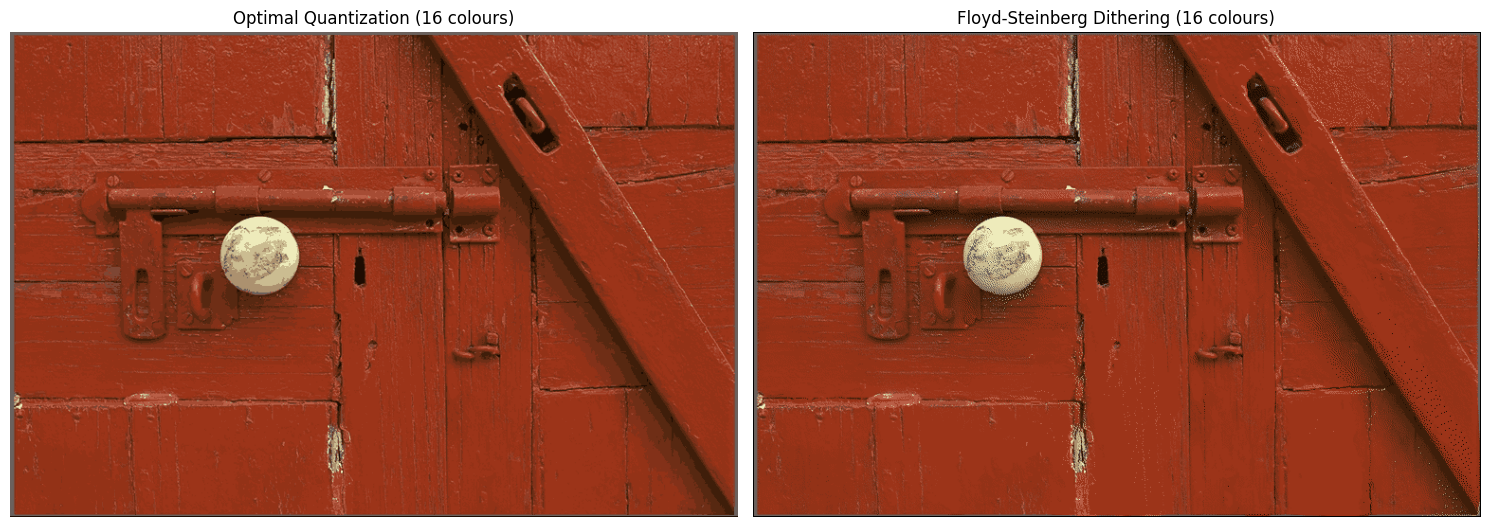

[ 16 colours]  Quantization error: 3.55  |  Dithering error: 5.28



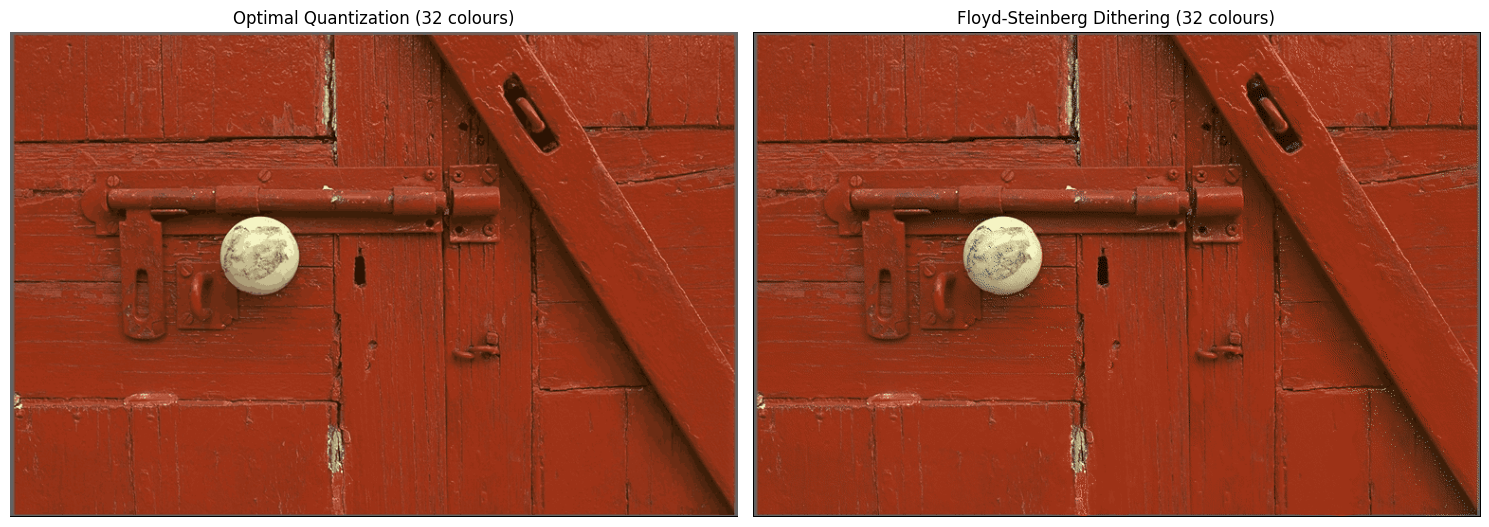

[ 32 colours]  Quantization error: 2.46  |  Dithering error: 3.90



In [ ]:
for n_colors in [16, 32, 256]:
    # Compute optimal palette via k-means
    kmeans = KMeans(n_clusters=n_colors, n_init=10, random_state=42).fit(
        np.reshape(img, (-1, 3))
    )
    palette = kmeans.cluster_centers_

    q, d = quantize_and_dither(img, palette)

    # --- Visualise ---
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    axes[0].imshow(q.astype(np.uint8))
    axes[0].set_title(f"Optimal Quantization ({n_colors} colours)")
    axes[0].axis("off")

    axes[1].imshow(d.astype(np.uint8))
    axes[1].set_title(f"Floyd-Steinberg Dithering ({n_colors} colours)")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

    q_err = np.mean(np.abs(img - q))
    d_err = np.mean(np.abs(img - d))
    print(
        f"[{n_colors:>3} colours]  Quantization error: {q_err:.2f}  |  Dithering error: {d_err:.2f}\n"
    )

### Bonus Answers

- **16 colours (k-means):** The dithered image already looks remarkably close to the original — much better than the 4-colour grayscale. Banding artefacts in the quantized version are almost entirely eliminated by dithering. The quantization error is lower than with the grayscale palette because k-means picks colours that are optimal for *this specific* image.

- **32 colours:** Both the quantized and dithered images improve further. The quantized version starts looking quite good on its own; dithering still smooths out subtle banding in gradients.

- **256 colours:** Virtually indistinguishable from the original for both methods. The average quantization error drops to a very small value, and there is little visual difference between optimal quantization and dithering at this palette size.